# Random Forest Model for classifying important taxa for classifying DiseaseStatus

In [15]:
import pandas as pd
import numpy as np
import os
import re
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder, label_binarize 
from itertools import cycle 
from scipy.stats import mannwhitneyu
from statsmodels.sandbox.stats.multicomp import multipletests
from scipy.stats import spearmanr

import matplotlib.pyplot as plt
import seaborn as sns

## Multiclass Classifier with hyperparatmeter tuning using "GridSearchCV"
### Three groups:
    - Disease Present
    - No Disease Present
    - Discrepant

--- Starting Random Forest Multi-Class Classification Analysis ---
OTU Table: otu_table_uclust_with_updated_taxonomy_05172025_78bats_singletsRemoved_78bats_filtered_domains_combined_by_genus_keep_blanks_species_column_removed_log(x+1).csv
Metadata: otu_metadata_uclust_updated_taxonomy_05162025.csv
Created output directory: random_forest_multiclass_diagnostics_log(x+1)
Using 'OTU_ID' as OTU/Taxon identifier column.
Expected taxonomy columns: ['Domain', 'Super Kingdom', 'Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus']
Identified 79 sample columns in OTU table.
Aligned data for multi-class classification: 78 samples, 617 taxa.
Target variable 'DiseaseStatus' encoded. Classes (3): ['Discrepant' 'Disease Present' 'No Disease Present']
  Discrepant -> 0
  Disease Present -> 1
  No Disease Present -> 2
Data split: 54 training samples, 24 testing samples.

Starting Hyperparameter Tuning for Random Forest Classifier (Multi-Class)...
Fitting 3 folds for each of 81 candidates, totalling 

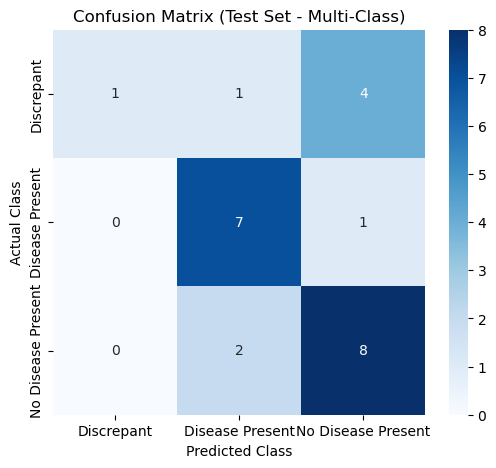

Multi-class ROC curve plot saved to: random_forest_multiclass_diagnostics_log(x+1)\roc_curve_multiclass_tuned_plot.png


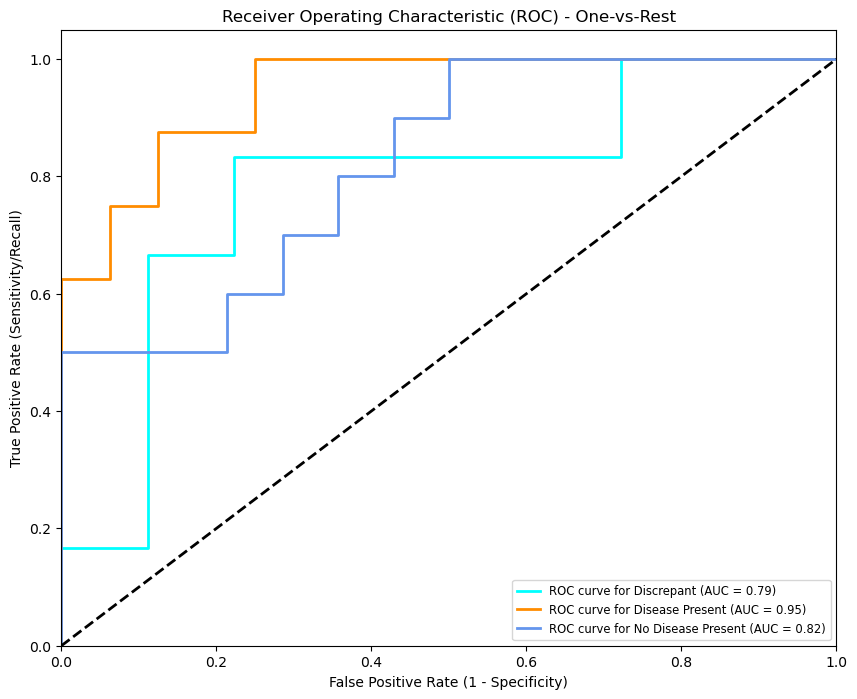


All taxa importances (annotated) saved to: random_forest_multiclass_diagnostics_log(x+1)\all_taxa_importances_annotated_multiclass_tuned.csv


C:\Users\derek\AppData\Local\Temp\ipykernel_20524\1278480505.py:282: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Display_Label', data=top_features, palette='viridis')


Feature importance plot saved to: random_forest_multiclass_diagnostics_log(x+1)\top_taxa_importances_plot_multiclass_tuned.png


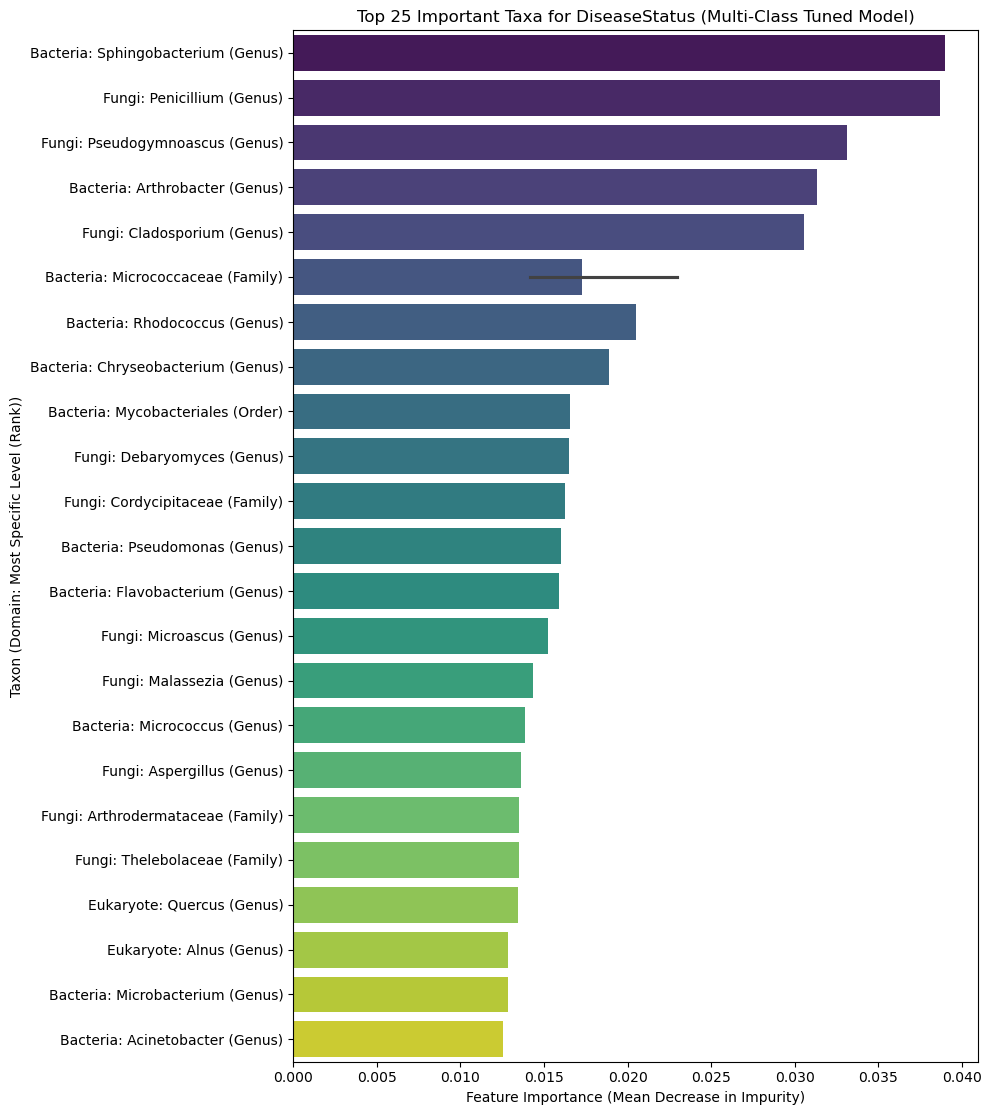

--- Random Forest Multi-Class Classification Analysis Complete ---

Top important taxa identified (from multi-class tuned model, annotated):
                          Display_Label  Importance
159  Bacteria: Sphingobacterium (Genus)    0.038978
127          Fungi: Penicillium (Genus)    0.038683
139     Fungi: Pseudogymnoascus (Genus)    0.033097
15       Bacteria: Arthrobacter (Genus)    0.031345
36          Fungi: Cladosporium (Genus)    0.030569


In [9]:
def get_most_specific_taxon_rf(row, tax_levels, uninformative_strings, fallback_id_str, domain_val):
    """
    Finds the most specific non-blank taxonomic assignment from a list of levels
    and formats it with the domain.
    """
    most_specific_name = fallback_id_str
    specific_level_name = "ID" 

    for level in tax_levels: 
        value = row.get(level) 
        if pd.notna(value):
            value_str = str(value).strip()
            if value_str.lower() not in uninformative_strings and value_str != "":
                most_specific_name = value_str
                specific_level_name = level
                break 

    domain_prefix = str(domain_val).strip()
    if pd.isna(domain_val) or domain_prefix.lower() in uninformative_strings or domain_prefix == "":
        domain_prefix = "Unknown_Domain"
    
    if specific_level_name == "ID": 
        if domain_prefix == "Unknown_Domain":
            return f"{most_specific_name} (ID)" 
        else:
            return f"{domain_prefix}: {most_specific_name} (ID)"
    else: 
        return f"{domain_prefix}: {most_specific_name} ({specific_level_name})"


def run_random_forest_taxa_importance(
    otu_table_path,
    metadata_path,
    output_dir="random_forest_multiclass_results", # Updated default output dir
    metadata_sample_id_col="#SampleID",
    grouping_variable_col="DiseaseStatus",
    num_taxonomy_cols=9, 
    random_state=42, 
    test_size=0.3,
    top_n_features_to_plot=20
):
    """
    Performs Random Forest multi-class classification 
    with hyperparameter tuning to identify important taxa.
    Generates confusion matrix heatmap and One-vs-Rest ROC curves.
    """
    print(f"--- Starting Random Forest Multi-Class Classification Analysis ---")
    print(f"OTU Table: {otu_table_path}")
    print(f"Metadata: {metadata_path}")

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Created output directory: {output_dir}")

    try:
        df_otu_full = pd.read_csv(otu_table_path)
    except FileNotFoundError:
        print(f"Error: OTU table file '{otu_table_path}' not found.")
        return None
    except Exception as e:
        print(f"Error loading OTU table: {e}")
        return None

    try:
        df_metadata = pd.read_csv(metadata_path)
    except FileNotFoundError:
        print(f"Error: Metadata file '{metadata_path}' not found.")
        return None
    except Exception as e:
        print(f"Error loading metadata: {e}")
        return None

    if df_otu_full.empty or df_metadata.empty:
        print("OTU table or metadata is empty. Aborting.")
        return None

    otu_id_col = df_otu_full.columns[0]
    print(f"Using '{otu_id_col}' as OTU/Taxon identifier column.")
    
    expected_taxonomy_cols = df_otu_full.columns[1 : 1 + num_taxonomy_cols].tolist()
    print(f"Expected taxonomy columns: {expected_taxonomy_cols}")
    df_taxonomy_map = df_otu_full[[otu_id_col] + expected_taxonomy_cols].set_index(otu_id_col)

    sample_col_pattern = re.compile(r'^[A-Z]\d{2}$')
    all_columns = df_otu_full.columns.tolist()
    potential_sample_cols_start_index = 1 + num_taxonomy_cols 
    sample_cols = [col for col in all_columns[potential_sample_cols_start_index:] if sample_col_pattern.match(col)]
    
    if not sample_cols:
        sample_cols = [col for col in all_columns if sample_col_pattern.match(col)]
        if not sample_cols:
            print("Error: No sample columns found matching pattern (e.g., A01).")
            return None
    print(f"Identified {len(sample_cols)} sample columns in OTU table.")

    df_abundances = df_otu_full.set_index(otu_id_col)[sample_cols]
    df_abundances = df_abundances.apply(pd.to_numeric, errors='coerce').fillna(0)
    X = df_abundances.T 
    feature_names_original = X.columns.tolist()

    if metadata_sample_id_col not in df_metadata.columns:
        print(f"Error: Metadata sample ID column '{metadata_sample_id_col}' not found.")
        return None
    if grouping_variable_col not in df_metadata.columns:
        print(f"Error: Grouping variable column '{grouping_variable_col}' not found in metadata.")
        return None
    
    df_metadata[metadata_sample_id_col] = df_metadata[metadata_sample_id_col].astype(str)
    # NO LONGER FILTERING METADATA FOR BINARY - Using all groups
    df_metadata_indexed = df_metadata.set_index(metadata_sample_id_col)

    common_samples = X.index.intersection(df_metadata_indexed.index)
    if len(common_samples) == 0:
        print("Error: No common samples between OTU table and metadata.")
        return None
    
    X_aligned = X.loc[common_samples]
    y_series = df_metadata_indexed.loc[common_samples, grouping_variable_col].fillna("UnknownGroup") # Handle potential NaNs
    print(f"Aligned data for multi-class classification: {len(common_samples)} samples, {X_aligned.shape[1]} taxa.")

    le = LabelEncoder()
    y_encoded = le.fit_transform(y_series)
    class_names = le.classes_ 
    n_classes = len(class_names)
    print(f"Target variable '{grouping_variable_col}' encoded. Classes ({n_classes}): {class_names}")
    for i, cls_name in enumerate(class_names):
        print(f"  {cls_name} -> {i}")
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_aligned, y_encoded, test_size=test_size, random_state=random_state, stratify=y_encoded
    )
    print(f"Data split: {len(X_train)} training samples, {len(X_test)} testing samples.")

    print(f"\nStarting Hyperparameter Tuning for Random Forest Classifier (Multi-Class)...")
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10], 
        'min_samples_leaf': [1, 2, 4]    
    }
    rf_base = RandomForestClassifier(random_state=random_state, class_weight='balanced')
    # Using 'f1_macro' for multi-class to treat all classes equally in optimization
    grid_search = GridSearchCV(estimator=rf_base, param_grid=param_grid, 
                               cv=3, n_jobs=-1, verbose=1, scoring='f1_macro') 
    grid_search.fit(X_train, y_train)

    print("\nHyperparameter tuning complete.")
    print(f"Best parameters found: {grid_search.best_params_}")
    print(f"Best F1 Macro score from GridSearchCV: {grid_search.best_score_:.4f}")

    best_rf_model = grid_search.best_estimator_
    
    y_pred = best_rf_model.predict(X_test)
    y_pred_proba = best_rf_model.predict_proba(X_test) # Probabilities for all classes

    accuracy = accuracy_score(y_test, y_pred)
    print(f"\n--- Model Evaluation on Test Set (Multi-Class Tuned Model) ---")
    print(f"Accuracy: {accuracy:.4f}")
    
    report_dict = classification_report(y_test, y_pred, target_names=class_names, zero_division=0, output_dict=True)
    report_df = pd.DataFrame(report_dict).transpose()
    print("\nClassification Report:")
    print(report_df)
    
    metrics_output_path = os.path.join(output_dir, "classification_metrics_multiclass_tuned.csv") 
    try:
        report_df.to_csv(metrics_output_path)
        print(f"Classification metrics saved to: {metrics_output_path}")
    except Exception as e:
        print(f"Error saving classification metrics: {e}")

    # --- Confusion Matrix Visualization ---
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
    print(cm_df)
    cm_output_path_csv = os.path.join(output_dir, "confusion_matrix_multiclass_tuned.csv") 
    try:
        cm_df.to_csv(cm_output_path_csv)
        print(f"Confusion matrix CSV saved to: {cm_output_path_csv}")
    except Exception as e:
        print(f"Error saving confusion matrix CSV: {e}")

    plt.figure(figsize=(max(6, n_classes*1.5), max(5, n_classes*1.2))) # Dynamic size
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix (Test Set - Multi-Class)')
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    cm_plot_output_path = os.path.join(output_dir, "confusion_matrix_multiclass_tuned_plot.png")
    try:
        plt.savefig(cm_plot_output_path, dpi=300, bbox_inches='tight')
        print(f"Confusion matrix plot saved to: {cm_plot_output_path}")
        plt.show()
    except Exception as e:
        print(f"Error saving confusion matrix plot: {e}")
    plt.close() 

    # --- One-vs-Rest ROC Curve and AUC for Multi-Class ---
    # Binarize the output
    y_test_binarized = label_binarize(y_test, classes=range(n_classes))

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve for {class_names[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity/Recall)')
    plt.title('Receiver Operating Characteristic (ROC) - One-vs-Rest')
    plt.legend(loc="lower right", fontsize='small')
    roc_plot_output_path = os.path.join(output_dir, "roc_curve_multiclass_tuned_plot.png")
    try:
        plt.savefig(roc_plot_output_path, dpi=300, bbox_inches='tight')
        print(f"Multi-class ROC curve plot saved to: {roc_plot_output_path}")
        plt.show()
    except Exception as e:
        print(f"Error saving multi-class ROC curve plot: {e}")
    plt.close() 


    # --- Feature Importances ---
    importances = best_rf_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Taxon_ID': feature_names_original, 
        'Importance': importances
    })

    feature_importance_df = pd.merge(feature_importance_df, df_taxonomy_map, left_on='Taxon_ID', right_index=True, how='left')
    
    taxonomic_hierarchy_levels = ['Genus', 'Family', 'Order', 'Class', 'Phylum', 'Kingdom', 'Super Kingdom']
    valid_tax_hierarchy = [level for level in taxonomic_hierarchy_levels if level in feature_importance_df.columns]

    uninformative_tax_strings_rf = [
        '', 'nan', 'none', 'na', '<na>', 'unassigned', 'unclassified', 
        'unknown', 'no blast hit', 'incertae sedis', 'metazoa', 
        'no classification', 'unknown_domain' 
    ]
    uninformative_tax_strings_rf = [s.lower() for s in uninformative_tax_strings_rf]

    feature_importance_df['Display_Label'] = feature_importance_df.apply(
        lambda row: get_most_specific_taxon_rf(row, valid_tax_hierarchy, uninformative_tax_strings_rf, row['Taxon_ID'], row.get('Domain')),
        axis=1
    )
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    feature_importance_output_path = os.path.join(output_dir, "all_taxa_importances_annotated_multiclass_tuned.csv") 
    feature_importance_df.to_csv(feature_importance_output_path, index=False)
    print(f"\nAll taxa importances (annotated) saved to: {feature_importance_output_path}")

    top_features = feature_importance_df.head(top_n_features_to_plot)
    
    if top_features.empty:
        print("No feature importances to plot.")
    else:
        plt.figure(figsize=(10, max(6, top_n_features_to_plot * 0.45))) 
        sns.barplot(x='Importance', y='Display_Label', data=top_features, palette='viridis') 
        plt.title(f'Top {top_n_features_to_plot} Important Taxa for {grouping_variable_col} (Multi-Class Tuned Model)')
        plt.xlabel('Feature Importance (Mean Decrease in Impurity)')
        plt.ylabel('Taxon (Domain: Most Specific Level (Rank))') 
        plt.tight_layout()
        
        plot_output_path = os.path.join(output_dir, "top_taxa_importances_plot_multiclass_tuned.png") 
        try:
            plt.savefig(plot_output_path, dpi=600)
            print(f"Feature importance plot saved to: {plot_output_path}")
            plt.show()
        except Exception as e:
            print(f"Error saving feature importance plot: {e}")
        plt.close() 
            
    print(f"--- Random Forest Multi-Class Classification Analysis Complete ---")
    return feature_importance_df


if __name__ == "__main__":
    otu_file = "otu_table_uclust_with_updated_taxonomy_05172025_78bats_singletsRemoved_78bats_filtered_domains_combined_by_genus_keep_blanks_species_column_removed_log(x+1).csv"
    meta_file = "otu_metadata_uclust_updated_taxonomy_05162025.csv" 
    
    metadata_sample_id_col_main = "SampleID" 
    metadata_grouping_col_main = "DiseaseStatus"
        
    num_taxonomy_cols_main = 8 
    output_directory_multiclass = "random_forest_multiclass_diagnostics_log(x+1)" # New output dir for multi-class

    if not os.path.exists(otu_file):
        print(f"CRITICAL ERROR: OTU table file '{otu_file}' was not found.")
    elif not os.path.exists(meta_file):
        print(f"CRITICAL ERROR: Metadata file '{meta_file}' was not found.")
    else:
        # Call the function without class1_name and class2_name for multi-class
        important_taxa_df = run_random_forest_taxa_importance(
            otu_table_path=otu_file,
            metadata_path=meta_file,
            output_dir=output_directory_multiclass,
            metadata_sample_id_col=metadata_sample_id_col_main,
            grouping_variable_col=metadata_grouping_col_main,
            # class1_name and class2_name are removed for multi-class
            num_taxonomy_cols=num_taxonomy_cols_main,
            top_n_features_to_plot=25 
        )
        if important_taxa_df is not None and not important_taxa_df.empty:
            print("\nTop important taxa identified (from multi-class tuned model, annotated):")
            print(important_taxa_df[['Display_Label', 'Importance']].head())


## Binary classifier with hyperparatmeter tuning using "GridSearchCV"
### Two Groups:
    - Disease Present
    - No Disease Present 
- Model will only be trained with the Disease Present and No Disease Present groups
- In a subseqent analysis I'll trying using this classifier to classify the data containing the "Discreptant" group and see how it handles those samples

--- Starting Random Forest Binary Classification Analysis (Disease Present vs No Disease Present) ---
OTU Table: otu_table_uclust_with_updated_taxonomy_05172025_78bats_singletsRemoved_78bats_filtered_domains_combined_by_genus_keep_blanks_species_column_removed.csv
Metadata: otu_metadata_uclust_updated_taxonomy_05162025.csv
Using 'OTU_ID' as OTU/Taxon identifier column.
Expected taxonomy columns: ['Domain', 'Super Kingdom', 'Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus']
Identified 79 sample columns in OTU table.
Filtered metadata for binary classification: 60 samples.
Aligned data for binary classification: 60 samples, 617 taxa.
Target variable 'DiseaseStatus' encoded for binary task. Classes: ['Disease Present' 'No Disease Present']
Positive class for ROC curve ('Disease Present') is encoded as: 0
Data split: 42 training samples, 18 testing samples.

Starting Hyperparameter Tuning for Random Forest Classifier (Binary)...
Fitting 3 folds for each of 81 candidates, totalling 2

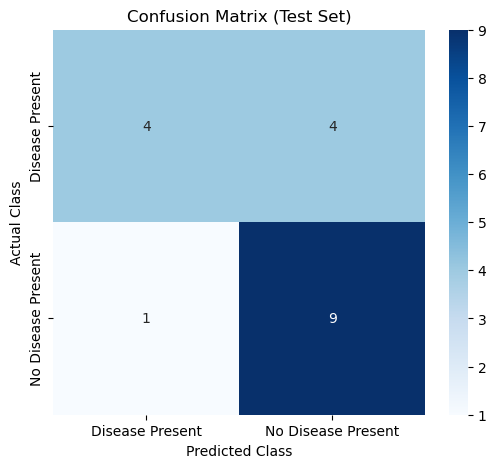

ROC curve plot saved to: random_forest_binary_disease_vs_no_disease_diagnostics\roc_curve_binary_tuned_plot.png


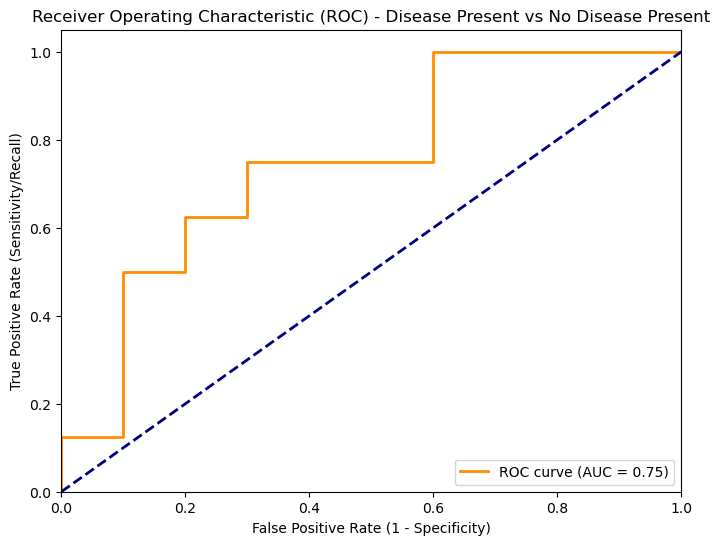


All taxa importances (annotated) saved to: random_forest_binary_disease_vs_no_disease_diagnostics\all_taxa_importances_annotated_binary_tuned.csv


C:\Users\derek\AppData\Local\Temp\ipykernel_20524\2221663192.py:285: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Display_Label', data=top_features, palette='viridis')


Feature importance plot saved to: random_forest_binary_disease_vs_no_disease_diagnostics\top_taxa_importances_plot_binary_tuned.png


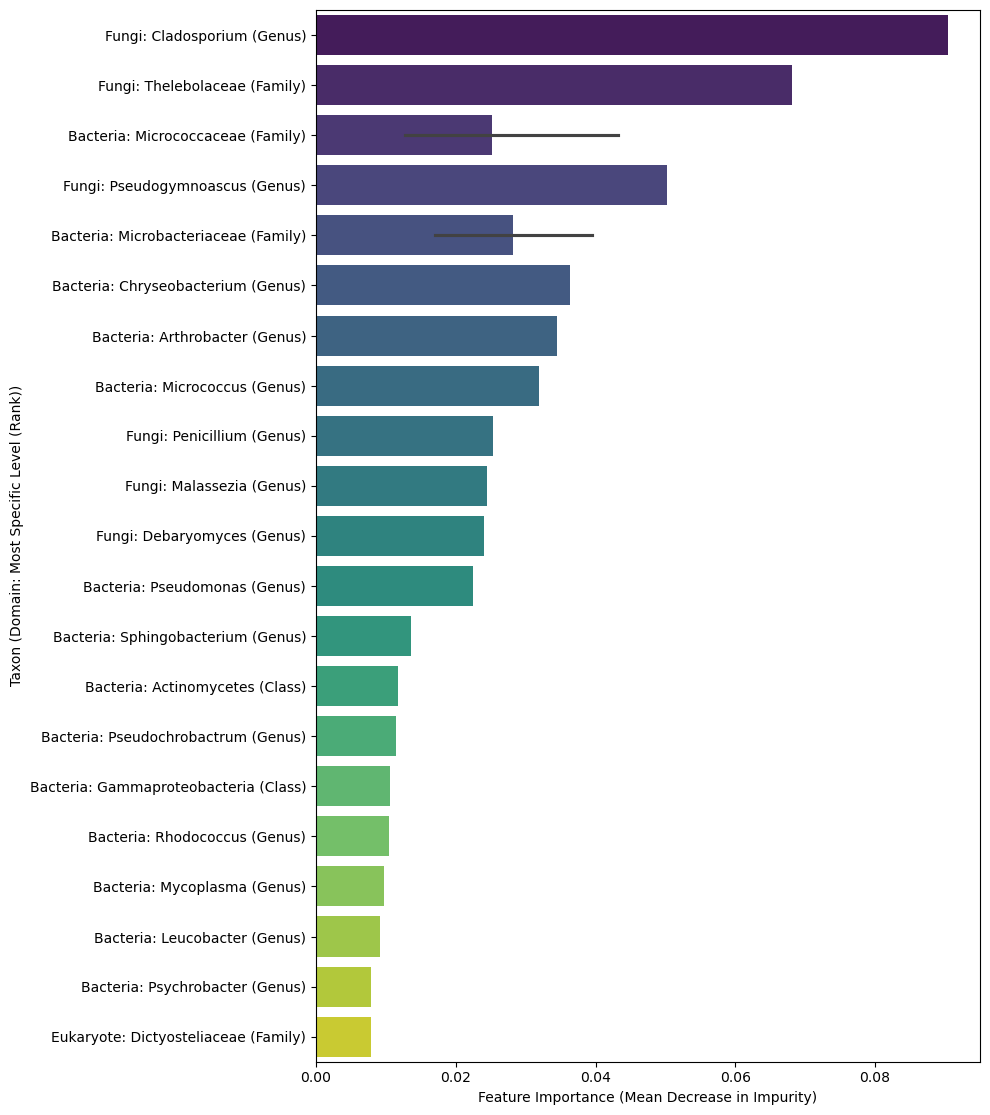

--- Random Forest Binary Classification Analysis Complete ---

Top important taxa identified (from binary tuned model, annotated):
                            Display_Label  Importance
36            Fungi: Cladosporium (Genus)    0.090483
582         Fungi: Thelebolaceae (Family)    0.068063
595     Bacteria: Micrococcaceae (Family)    0.052627
139       Fungi: Pseudogymnoascus (Genus)    0.050203
393  Bacteria: Microbacteriaceae (Family)    0.039437


In [12]:
def get_most_specific_taxon_rf(row, tax_levels, uninformative_strings, fallback_id_str, domain_val):
    """
    Finds the most specific non-blank taxonomic assignment from a list of levels
    and formats it with the domain.
    """
    most_specific_name = fallback_id_str
    specific_level_name = "ID" 

    for level in tax_levels: 
        value = row.get(level) 
        if pd.notna(value):
            value_str = str(value).strip()
            if value_str.lower() not in uninformative_strings and value_str != "":
                most_specific_name = value_str
                specific_level_name = level
                break 

    domain_prefix = str(domain_val).strip()
    if pd.isna(domain_val) or domain_prefix.lower() in uninformative_strings or domain_prefix == "":
        domain_prefix = "Unknown_Domain"
    
    if specific_level_name == "ID": 
        if domain_prefix == "Unknown_Domain":
            return f"{most_specific_name} (ID)" 
        else:
            return f"{domain_prefix}: {most_specific_name} (ID)"
    else: 
        return f"{domain_prefix}: {most_specific_name} ({specific_level_name})"


def run_random_forest_taxa_importance(
    otu_table_path,
    metadata_path,
    output_dir="random_forest_results_binary", 
    metadata_sample_id_col="#SampleID",
    grouping_variable_col="DiseaseStatus",
    class1_name="Disease Present", 
    class2_name="No Disease Present", 
    num_taxonomy_cols=9, 
    random_state=42, 
    test_size=0.3,
    top_n_features_to_plot=20
):
    """
    Performs Random Forest binary classification (class1 vs class2) 
    with hyperparameter tuning to identify important taxa.
    Generates confusion matrix heatmap and ROC curve.
    """
    print(f"--- Starting Random Forest Binary Classification Analysis ({class1_name} vs {class2_name}) ---")
    print(f"OTU Table: {otu_table_path}")
    print(f"Metadata: {metadata_path}")

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Created output directory: {output_dir}")

    try:
        df_otu_full = pd.read_csv(otu_table_path)
    except FileNotFoundError:
        print(f"Error: OTU table file '{otu_table_path}' not found.")
        return None
    except Exception as e:
        print(f"Error loading OTU table: {e}")
        return None

    try:
        df_metadata = pd.read_csv(metadata_path)
    except FileNotFoundError:
        print(f"Error: Metadata file '{metadata_path}' not found.")
        return None
    except Exception as e:
        print(f"Error loading metadata: {e}")
        return None

    if df_otu_full.empty or df_metadata.empty:
        print("OTU table or metadata is empty. Aborting.")
        return None

    otu_id_col = df_otu_full.columns[0]
    print(f"Using '{otu_id_col}' as OTU/Taxon identifier column.")
    
    expected_taxonomy_cols = df_otu_full.columns[1 : 1 + num_taxonomy_cols].tolist()
    print(f"Expected taxonomy columns: {expected_taxonomy_cols}")
    df_taxonomy_map = df_otu_full[[otu_id_col] + expected_taxonomy_cols].set_index(otu_id_col)

    sample_col_pattern = re.compile(r'^[A-Z]\d{2}$')
    all_columns = df_otu_full.columns.tolist()
    potential_sample_cols_start_index = 1 + num_taxonomy_cols 
    sample_cols = [col for col in all_columns[potential_sample_cols_start_index:] if sample_col_pattern.match(col)]
    
    if not sample_cols:
        sample_cols = [col for col in all_columns if sample_col_pattern.match(col)]
        if not sample_cols:
            print("Error: No sample columns found matching pattern (e.g., A01).")
            return None
    print(f"Identified {len(sample_cols)} sample columns in OTU table.")

    df_abundances = df_otu_full.set_index(otu_id_col)[sample_cols]
    df_abundances = df_abundances.apply(pd.to_numeric, errors='coerce').fillna(0)
    X = df_abundances.T 
    feature_names_original = X.columns.tolist()

    if metadata_sample_id_col not in df_metadata.columns:
        print(f"Error: Metadata sample ID column '{metadata_sample_id_col}' not found.")
        return None
    if grouping_variable_col not in df_metadata.columns:
        print(f"Error: Grouping variable column '{grouping_variable_col}' not found in metadata.")
        return None
    
    df_metadata[metadata_sample_id_col] = df_metadata[metadata_sample_id_col].astype(str)
    
    classes_to_keep = [class1_name, class2_name]
    df_metadata_filtered = df_metadata[df_metadata[grouping_variable_col].isin(classes_to_keep)].copy()
    
    if df_metadata_filtered.empty:
        print(f"Error: No samples found in metadata for classes '{class1_name}' or '{class2_name}'.")
        return None
    print(f"Filtered metadata for binary classification: {len(df_metadata_filtered)} samples.")
    
    df_metadata_indexed = df_metadata_filtered.set_index(metadata_sample_id_col)

    common_samples = X.index.intersection(df_metadata_indexed.index)
    if len(common_samples) == 0:
        print("Error: No common samples between OTU table and filtered metadata.")
        return None
    
    X_aligned = X.loc[common_samples]
    y_series = df_metadata_indexed.loc[common_samples, grouping_variable_col]
    print(f"Aligned data for binary classification: {len(common_samples)} samples, {X_aligned.shape[1]} taxa.")

    le = LabelEncoder()
    y_encoded = le.fit_transform(y_series)
    class_names = le.classes_ 
    print(f"Target variable '{grouping_variable_col}' encoded for binary task. Classes: {class_names}")
    # Determine which encoded label corresponds to class1_name (positive class for ROC)
    # This assumes class1_name is your "positive" class. If not, adjust accordingly.
    try:
        positive_class_label_encoded = le.transform([class1_name])[0]
        print(f"Positive class for ROC curve ('{class1_name}') is encoded as: {positive_class_label_encoded}")
    except ValueError:
        print(f"Error: class1_name '{class1_name}' not found in LabelEncoder classes. Cannot determine positive class for ROC.")
        positive_class_label_encoded = 1 # Default to 1 if unsure, might need adjustment
        
    if len(class_names) != 2:
        print(f"Warning: Expected 2 classes after filtering, but found {len(class_names)}. Check class names provided.")

    X_train, X_test, y_train, y_test = train_test_split(
        X_aligned, y_encoded, test_size=test_size, random_state=random_state, stratify=y_encoded
    )
    print(f"Data split: {len(X_train)} training samples, {len(X_test)} testing samples.")

    print(f"\nStarting Hyperparameter Tuning for Random Forest Classifier (Binary)...")
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10], 
        'min_samples_leaf': [1, 2, 4]    
    }
    rf_base = RandomForestClassifier(random_state=random_state, class_weight='balanced')
    grid_search = GridSearchCV(estimator=rf_base, param_grid=param_grid, 
                               cv=3, n_jobs=-1, verbose=1, scoring='f1_weighted') 
    grid_search.fit(X_train, y_train)

    print("\nHyperparameter tuning complete.")
    print(f"Best parameters found: {grid_search.best_params_}")
    print(f"Best F1 Weighted score from GridSearchCV: {grid_search.best_score_:.4f}")

    best_rf_model = grid_search.best_estimator_
    
    y_pred = best_rf_model.predict(X_test)
    y_pred_proba = best_rf_model.predict_proba(X_test)[:, positive_class_label_encoded] # Probabilities for the positive class

    accuracy = accuracy_score(y_test, y_pred)
    print(f"\n--- Model Evaluation on Test Set (Binary Tuned Model) ---")
    print(f"Accuracy: {accuracy:.4f}")
    
    report_dict = classification_report(y_test, y_pred, target_names=class_names, zero_division=0, output_dict=True)
    report_df = pd.DataFrame(report_dict).transpose()
    print("\nClassification Report:")
    print(report_df)
    
    metrics_output_path = os.path.join(output_dir, "classification_metrics_binary_tuned.csv") 
    try:
        report_df.to_csv(metrics_output_path)
        print(f"Classification metrics saved to: {metrics_output_path}")
    except Exception as e:
        print(f"Error saving classification metrics: {e}")

    # --- Confusion Matrix Visualization ---
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
    print(cm_df)
    cm_output_path_csv = os.path.join(output_dir, "confusion_matrix_binary_tuned.csv") 
    try:
        cm_df.to_csv(cm_output_path_csv)
        print(f"Confusion matrix CSV saved to: {cm_output_path_csv}")
    except Exception as e:
        print(f"Error saving confusion matrix CSV: {e}")

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix (Test Set)')
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    cm_plot_output_path = os.path.join(output_dir, "confusion_matrix_binary_tuned_plot.png")
    try:
        plt.savefig(cm_plot_output_path, dpi=300, bbox_inches='tight')
        print(f"Confusion matrix plot saved to: {cm_plot_output_path}")
        plt.show()
    except Exception as e:
        print(f"Error saving confusion matrix plot: {e}")
    plt.close() # Close the figure

    # --- ROC Curve and AUC ---
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=positive_class_label_encoded)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity/Recall)')
    plt.title(f'Receiver Operating Characteristic (ROC) - {class1_name} vs {class2_name}')
    plt.legend(loc="lower right")
    roc_plot_output_path = os.path.join(output_dir, "roc_curve_binary_tuned_plot.png")
    try:
        plt.savefig(roc_plot_output_path, dpi=300, bbox_inches='tight')
        print(f"ROC curve plot saved to: {roc_plot_output_path}")
        plt.show()
    except Exception as e:
        print(f"Error saving ROC curve plot: {e}")
    plt.close() # Close the figure


    # --- Feature Importances ---
    importances = best_rf_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Taxon_ID': feature_names_original, 
        'Importance': importances
    })

    feature_importance_df = pd.merge(feature_importance_df, df_taxonomy_map, left_on='Taxon_ID', right_index=True, how='left')
    
    taxonomic_hierarchy_levels = ['Genus', 'Family', 'Order', 'Class', 'Phylum', 'Kingdom', 'Super Kingdom']
    valid_tax_hierarchy = [level for level in taxonomic_hierarchy_levels if level in feature_importance_df.columns]

    uninformative_tax_strings_rf = [
        '', 'nan', 'none', 'na', '<na>', 'unassigned', 'unclassified', 
        'unknown', 'no blast hit', 'incertae sedis', 'metazoa', 
        'no classification', 'unknown_domain' 
    ]
    uninformative_tax_strings_rf = [s.lower() for s in uninformative_tax_strings_rf]

    feature_importance_df['Display_Label'] = feature_importance_df.apply(
        lambda row: get_most_specific_taxon_rf(row, valid_tax_hierarchy, uninformative_tax_strings_rf, row['Taxon_ID'], row.get('Domain')),
        axis=1
    )
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    feature_importance_output_path = os.path.join(output_dir, "all_taxa_importances_annotated_binary_tuned.csv") 
    feature_importance_df.to_csv(feature_importance_output_path, index=False)
    print(f"\nAll taxa importances (annotated) saved to: {feature_importance_output_path}")

    top_features = feature_importance_df.head(top_n_features_to_plot)
    
    if top_features.empty:
        print("No feature importances to plot.")
    else:
        plt.figure(figsize=(10, max(6, top_n_features_to_plot * 0.45))) 
        sns.barplot(x='Importance', y='Display_Label', data=top_features, palette='viridis') 
        # plt.title(f'Top {top_n_features_to_plot} Important Taxa for {class1_name} vs {class2_name} (Tuned Model)')
        plt.xlabel('Feature Importance (Mean Decrease in Impurity)')
        plt.ylabel('Taxon (Domain: Most Specific Level (Rank))') 
        plt.tight_layout()
        
        plot_output_path = os.path.join(output_dir, "top_taxa_importances_plot_binary_tuned.png") 
        try:
            plt.savefig(plot_output_path, dpi=300)
            print(f"Feature importance plot saved to: {plot_output_path}")
            plt.show()
        except Exception as e:
            print(f"Error saving feature importance plot: {e}")
        plt.close() # Close the figure
            
    print(f"--- Random Forest Binary Classification Analysis Complete ---")
    return feature_importance_df


if __name__ == "__main__":
    otu_file = "otu_table_uclust_with_updated_taxonomy_05172025_78bats_singletsRemoved_78bats_filtered_domains_combined_by_genus_keep_blanks_species_column_removed.csv"
    meta_file = "otu_metadata_uclust_updated_taxonomy_05162025.csv" 
    
    metadata_sample_id_col_main = "SampleID" 
    metadata_grouping_col_main = "DiseaseStatus"
    
    class_1 = "Disease Present" # Ensure this matches your metadata
    class_2 = "No Disease Present" # Ensure this matches your metadata
    
    num_taxonomy_cols_main = 8 
    output_directory_binary = "random_forest_binary_disease_vs_no_disease_diagnostics" # New output dir

    if not os.path.exists(otu_file):
        print(f"CRITICAL ERROR: OTU table file '{otu_file}' was not found.")
    elif not os.path.exists(meta_file):
        print(f"CRITICAL ERROR: Metadata file '{meta_file}' was not found.")
    else:
        important_taxa_df = run_random_forest_taxa_importance(
            otu_table_path=otu_file,
            metadata_path=meta_file,
            output_dir=output_directory_binary,
            metadata_sample_id_col=metadata_sample_id_col_main,
            grouping_variable_col=metadata_grouping_col_main,
            class1_name=class_1, 
            class2_name=class_2, 
            num_taxonomy_cols=num_taxonomy_cols_main,
            top_n_features_to_plot=25 
        )
        if important_taxa_df is not None and not important_taxa_df.empty:
            print("\nTop important taxa identified (from binary tuned model, annotated):")
            print(important_taxa_df[['Display_Label', 'Importance']].head())


### Plotting the relative abundance of the top 25 taxa
- bacteria and fungi on separate panels

--- Starting Plot Generation for Top Taxa Relative Abundance (Combined Clean Names) ---
Loaded data: Importance (Shape: (617, 11)), OTU (Shape: (617, 88)), Metadata (Shape: (78, 27))
Identified top 25 original important Taxon_IDs.
Number of unique Clean_Taxon_Names to plot: 21

Statistical test results saved to: top_25_taxa_abundance_combined_clean_names_stats.csv

Plot saved to 'top_25_taxa_abundance_combined_clean_names.png'


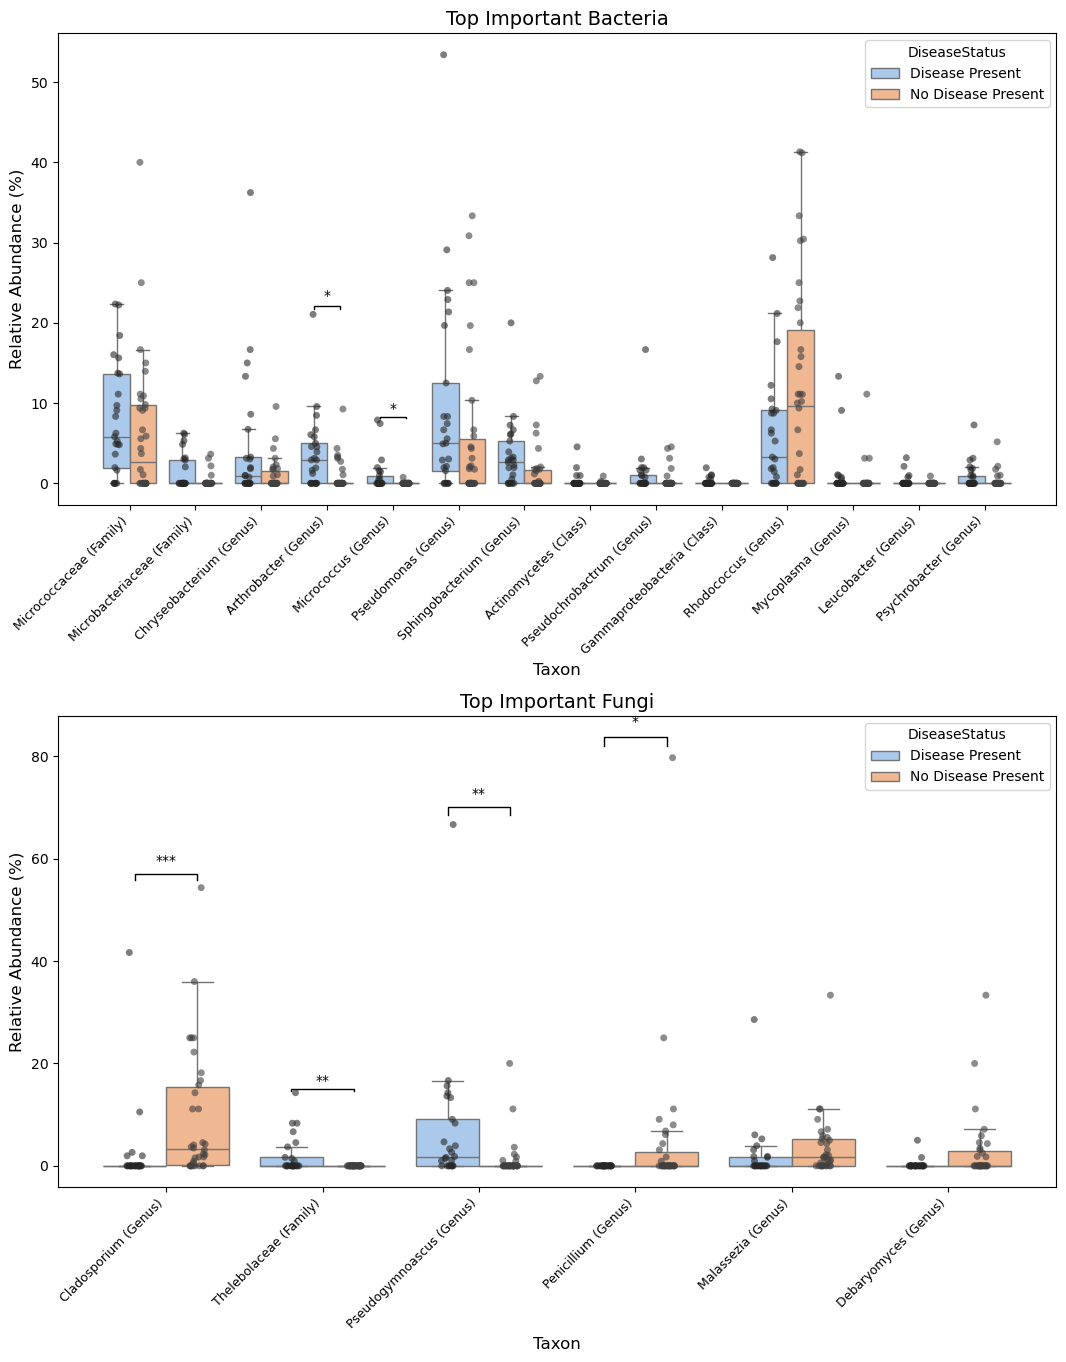

--- Plotting script finished ---


In [13]:
def get_domain_and_clean_name_from_display_label(display_label):
    """
    Extracts the Domain and a cleaner taxon name from the Display_Label.
    """
    if pd.isna(display_label):
        return "Unknown", "Unknown"
    
    parts = str(display_label).split(':', 1)
    if len(parts) == 2:
        domain = parts[0].strip()
        name_and_level = parts[1].strip()
        return domain, name_and_level
    else:
        if "(ID)" in display_label and "Unknown_Domain" not in display_label: 
             return "Unknown_Domain", display_label 
        return "Unknown", display_label 

def plot_top_taxa_relative_abundance(
    feature_importance_csv_path,
    otu_table_csv_path,
    metadata_csv_path,
    output_plot_path="top_taxa_relative_abundance_panels.png",
    output_stats_csv_path="top_taxa_stats_results.csv", 
    metadata_sample_id_col="#SampleID",
    grouping_variable_col="DiseaseStatus",
    class1_name="Disease Present",
    class2_name="No Disease Present",
    otu_id_col_in_otu_table=None, 
    num_taxonomy_cols_in_otu_table=9,
    top_n_taxa=25,
    significance_threshold=0.05
):
    """
    Plots relative abundance of top N RF taxa (combined by Clean_Taxon_Name), 
    separated by Domain, grouped by DiseaseStatus.
    Relative abundance is based on the total sum of ALL taxa in each sample.
    Performs Mann-Whitney U test with Bonferroni correction. Saves stats to CSV.
    """
    print("--- Starting Plot Generation for Top Taxa Relative Abundance (Combined Clean Names) ---")

    # 1. Load Data
    try:
        df_importance = pd.read_csv(feature_importance_csv_path)
    except FileNotFoundError:
        print(f"Error: Feature importance file '{feature_importance_csv_path}' not found.")
        return
    df_otu_full = pd.read_csv(otu_table_csv_path)
    df_metadata = pd.read_csv(metadata_csv_path)
    print(f"Loaded data: Importance (Shape: {df_importance.shape}), OTU (Shape: {df_otu_full.shape}), Metadata (Shape: {df_metadata.shape})")

    if not all(col in df_importance.columns for col in ['Taxon_ID', 'Importance', 'Display_Label']):
        print("Error: Feature importance CSV must contain 'Taxon_ID', 'Importance', and 'Display_Label' columns.")
        return

    # 2. Identify Top N Original Taxa and process their names
    df_top_original_taxa = df_importance.nlargest(top_n_taxa, 'Importance').copy()
    if df_top_original_taxa.empty:
        print(f"No taxa found in the top {top_n_taxa} from the importance file.")
        return
    print(f"Identified top {len(df_top_original_taxa)} original important Taxon_IDs.")

    df_top_original_taxa[['Extracted_Domain', 'Clean_Taxon_Name']] = df_top_original_taxa['Display_Label'].apply(
        lambda x: pd.Series(get_domain_and_clean_name_from_display_label(x))
    )
    
    # Create a source for plot order based on unique Clean_Taxon_Name, summing importances
    df_plot_order_source = df_top_original_taxa.groupby(['Extracted_Domain', 'Clean_Taxon_Name']) \
                                           .agg(Total_Importance=('Importance', 'sum'),
                                                Original_Taxon_IDs=('Taxon_ID', lambda x: list(set(x)))) \
                                           .reset_index() \
                                           .sort_values(by='Total_Importance', ascending=False)
    print(f"Number of unique Clean_Taxon_Names to plot: {len(df_plot_order_source)}")


    # 3. Prepare Abundance Data - Summing counts for same Clean_Taxon_Name
    if otu_id_col_in_otu_table is None:
        otu_id_col_in_otu_table = df_otu_full.columns[0]
    if otu_id_col_in_otu_table not in df_otu_full.columns:
        print(f"Error: OTU ID column '{otu_id_col_in_otu_table}' not found in OTU table.")
        return

    # Map Clean_Taxon_Name and Extracted_Domain to the full OTU table for relevant OTUs
    # We only care about OTUs that were in the top N original list
    map_original_to_clean = df_top_original_taxa.set_index('Taxon_ID')[['Clean_Taxon_Name', 'Extracted_Domain']]
    
    df_otu_full_with_clean_names = df_otu_full.merge(
        map_original_to_clean, 
        left_on=otu_id_col_in_otu_table, 
        right_index=True, 
        how='inner' # Keep only OTUs that are in our top list
    )

    if df_otu_full_with_clean_names.empty:
        print(f"Error: None of the top {top_n_taxa} Taxon_IDs were found in the OTU table after attempting to map clean names.")
        return

    # Identify sample columns
    sample_col_pattern = re.compile(r'^[A-Z]\d{2}$')
    all_columns_otu = df_otu_full.columns.tolist()
    potential_sample_cols_start_index = 1 + num_taxonomy_cols_in_otu_table 
    sample_cols_otu = [col for col in all_columns_otu[potential_sample_cols_start_index:] if sample_col_pattern.match(col)]
    if not sample_cols_otu: sample_cols_otu = [col for col in all_columns_otu if sample_col_pattern.match(col)]
    if not sample_cols_otu: print("Error: No sample columns found in OTU table."); return
        
    # Convert sample columns to numeric before grouping
    for col in sample_cols_otu:
        df_otu_full_with_clean_names[col] = pd.to_numeric(df_otu_full_with_clean_names[col], errors='coerce').fillna(0)

    # Group by Clean_Taxon_Name and sum counts
    # Keep Extracted_Domain for later use if needed, though it should be consistent per Clean_Taxon_Name
    df_summed_abundances_by_clean_name = df_otu_full_with_clean_names.groupby('Clean_Taxon_Name')[sample_cols_otu].sum()

    # --- RELATIVE ABUNDANCE CALCULATION (based on total sum of ALL taxa) ---
    otu_id_col_for_full_sum = df_otu_full.columns[0] 
    df_all_numeric_abundances = df_otu_full.set_index(otu_id_col_for_full_sum)[sample_cols_otu].apply(pd.to_numeric, errors='coerce').fillna(0)
    total_sum_per_sample_all_taxa = df_all_numeric_abundances.sum(axis=0) 
    total_sum_per_sample_all_taxa[total_sum_per_sample_all_taxa == 0] = 1 

    df_relative_abundances = df_summed_abundances_by_clean_name.div(total_sum_per_sample_all_taxa, axis='columns') * 100
    # --- END OF RELATIVE ABUNDANCE CALCULATION ---

    df_rel_abund_transposed = df_relative_abundances.T # Samples as rows, Clean_Taxon_Names as columns
    
    # Merge with metadata
    if metadata_sample_id_col not in df_metadata.columns or grouping_variable_col not in df_metadata.columns:
        print(f"Error: Required metadata columns ('{metadata_sample_id_col}', '{grouping_variable_col}') not found.")
        return
        
    df_metadata[metadata_sample_id_col] = df_metadata[metadata_sample_id_col].astype(str)
    plot_data_merged = pd.merge(df_rel_abund_transposed, 
                                df_metadata[[metadata_sample_id_col, grouping_variable_col]], 
                                left_index=True, right_on=metadata_sample_id_col)
    
    classes_to_plot = [class1_name, class2_name]
    plot_data_filtered_groups = plot_data_merged[plot_data_merged[grouping_variable_col].isin(classes_to_plot)]
    if plot_data_filtered_groups.empty: print(f"No data for groups: {classes_to_plot}"); return

    # Melt for plotting: value_vars are now the Clean_Taxon_Names
    clean_taxon_names_to_plot = df_plot_order_source['Clean_Taxon_Name'].unique().tolist()
    
    plot_data_melted = pd.melt(plot_data_filtered_groups, 
                               id_vars=[metadata_sample_id_col, grouping_variable_col], 
                               value_vars=[col for col in clean_taxon_names_to_plot if col in plot_data_filtered_groups.columns], 
                               var_name='Clean_Taxon_Name', # var_name is now Clean_Taxon_Name
                               value_name='RelativeAbundance')
    
    # Add Extracted_Domain to melted data for faceting
    plot_data_melted = pd.merge(plot_data_melted, 
                                df_plot_order_source[['Clean_Taxon_Name', 'Extracted_Domain']], # Get domain from our new source
                                on='Clean_Taxon_Name', 
                                how='left')
    if plot_data_melted.empty: print("Melted data is empty."); return

    # --- Statistical Testing and Plotting ---
    all_stats_results = []
    plt.style.use('seaborn-v0_8-pastel')

    unique_domains_to_plot = df_plot_order_source['Extracted_Domain'].str.lower().unique()
    panel_data_map_plot = {} 
    if 'bacteria' in unique_domains_to_plot: panel_data_map_plot['Bacteria'] = plot_data_melted[plot_data_melted['Extracted_Domain'].str.lower() == 'bacteria']
    if 'fungi' in unique_domains_to_plot: panel_data_map_plot['Fungi'] = plot_data_melted[plot_data_melted['Extracted_Domain'].str.lower() == 'fungi']

    num_panels_plot = len(panel_data_map_plot)
    if num_panels_plot == 0:
        print("No Bacteria or Fungi data to plot based on Extracted_Domain from top taxa.")
        return

    fig, axes = plt.subplots(nrows=num_panels_plot, ncols=1, figsize=(12, 7 * num_panels_plot), sharex=False, squeeze=False)
    ax_idx = 0

    for domain_name, df_domain_plot_data in panel_data_map_plot.items():
        current_ax = axes[ax_idx, 0]
        # Get plot order for this specific domain from df_plot_order_source
        panel_taxa_order = df_plot_order_source[df_plot_order_source['Extracted_Domain'].str.lower() == domain_name.lower()]['Clean_Taxon_Name'].tolist()
        
        if not panel_taxa_order:
            print(f"No taxa to plot for domain: {domain_name}")
            if num_panels_plot == 1: current_ax.set_visible(False)
            ax_idx +=1
            continue
            
        df_domain_plot_data_ordered = df_domain_plot_data[df_domain_plot_data['Clean_Taxon_Name'].isin(panel_taxa_order)]


        sns.boxplot(x='Clean_Taxon_Name', y='RelativeAbundance', hue=grouping_variable_col,
                    data=df_domain_plot_data_ordered, ax=current_ax, showfliers=False, 
                    order=panel_taxa_order, palette="pastel") 
        sns.stripplot(x='Clean_Taxon_Name', y='RelativeAbundance', hue=grouping_variable_col,
                      data=df_domain_plot_data_ordered, ax=current_ax, dodge=True, jitter=True,
                      palette="dark:.25", alpha=0.6, legend=False, 
                      order=panel_taxa_order) 
        current_ax.set_title(f'Top Important {domain_name}', fontsize=14)
        current_ax.set_xlabel('Taxon', fontsize=12)
        current_ax.set_ylabel('Relative Abundance (%)', fontsize=12)
        
        current_ax.set_xticks(range(len(panel_taxa_order)))
        current_ax.set_xticklabels(panel_taxa_order, rotation=45, ha='right', fontsize=9)

        current_ax.legend(title=grouping_variable_col, loc='upper right')

        # --- Statistical Annotation ---
        raw_p_values_panel = []
        taxa_tested_in_panel = [] 
        for i, taxon_name_plot in enumerate(panel_taxa_order): 
            taxon_data_current = df_domain_plot_data_ordered[df_domain_plot_data_ordered['Clean_Taxon_Name'] == taxon_name_plot]
            group1_data_for_stats = taxon_data_current[taxon_data_current[grouping_variable_col] == class1_name]['RelativeAbundance'].dropna()
            group2_data_for_stats = taxon_data_current[taxon_data_current[grouping_variable_col] == class2_name]['RelativeAbundance'].dropna()
            
            if len(group1_data_for_stats) >= 1 and len(group2_data_for_stats) >= 1:
                try:
                    _, p_val = mannwhitneyu(group1_data_for_stats, group2_data_for_stats, alternative='two-sided')
                    raw_p_values_panel.append(p_val)
                    taxa_tested_in_panel.append(taxon_name_plot)
                except ValueError: 
                    raw_p_values_panel.append(1.0)
                    taxa_tested_in_panel.append(taxon_name_plot)
            else:
                print(f"  Skipping stats for {taxon_name_plot} in {domain_name}: not enough data in one or both groups.")
        
        if raw_p_values_panel: 
            reject, corrected_p_values_bonf, _, _ = multipletests(raw_p_values_panel, alpha=significance_threshold, method='bonferroni')
            for i, taxon_name_tested in enumerate(taxa_tested_in_panel):
                all_stats_results.append({
                    'Domain': domain_name,
                    'Taxon': taxon_name_tested, # This is Clean_Taxon_Name
                    'Raw_P_Value': raw_p_values_panel[i],
                    'Corrected_P_Value': corrected_p_values_bonf[i],
                    'Significant_After_Correction': reject[i]
                })
                
                if reject[i]: # If significant after correction
                    y_max_taxon_data = df_domain_plot_data_ordered[
                        (df_domain_plot_data_ordered['Clean_Taxon_Name'] == taxon_name_tested)
                    ]['RelativeAbundance'].max()
                    
                    line_y = y_max_taxon_data + (0.05 * y_max_taxon_data) if y_max_taxon_data > 0 else 0.05 
                    text_y = line_y + (0.02 * y_max_taxon_data) if y_max_taxon_data > 0 else 0.07
                    
                    # Get current tick index for annotation
                    current_tick_idx = panel_taxa_order.index(taxon_name_tested)
                    x_start, x_end = current_tick_idx - 0.2, current_tick_idx + 0.2
                    
                    current_ax.plot([x_start, x_start, x_end, x_end], 
                                    [line_y*0.98, line_y, line_y, line_y*0.98], lw=1, c='black')
                    p_corrected_val = corrected_p_values_bonf[i]
                    p_text = "***" if p_corrected_val < 0.001 else ("**" if p_corrected_val < 0.01 else "*")
                    current_ax.text((x_start + x_end) / 2, text_y, p_text, ha='center', va='bottom', color='black', fontsize=10)
        ax_idx += 1
    
    if num_panels_plot < axes.shape[0]:
        for i in range(num_panels_plot, axes.shape[0]):
            fig.delaxes(axes[i,0])

    # fig.suptitle(f'Relative Abundance of Top RF Features ({class1_name} vs {class2_name}) with Significance', fontsize=16, y=1.02)
    plt.tight_layout(rect=[0, 0, 0.9, 0.98]) 

    # Save statistical results
    if all_stats_results:
        stats_df = pd.DataFrame(all_stats_results)
        try:
            stats_df.to_csv(output_stats_csv_path, index=False)
            print(f"\nStatistical test results saved to: {output_stats_csv_path}")
        except Exception as e:
            print(f"Error saving statistical results CSV: {e}")
    else:
        print("\nNo statistical tests were performed (e.g., due to insufficient data).")

    try:
        plt.savefig(output_plot_path, dpi=300, bbox_inches='tight')
        print(f"\nPlot saved to '{output_plot_path}'")
        plt.show()
    except Exception as e:
        print(f"Error saving plot: {e}")
    plt.close()

    print("--- Plotting script finished ---")


if __name__ == "__main__":
    feature_importance_file = "random_forest_binary_disease_vs_no_disease_diagnostics/all_taxa_importances_annotated_binary_tuned.csv" 
    otu_table_file = "otu_table_uclust_with_updated_taxonomy_05172025_78bats_singletsRemoved_78bats_filtered_domains_combined_by_genus_keep_blanks_species_column_removed.csv"
    meta_file = "otu_metadata_uclust_updated_taxonomy_05162025.csv" 
    
    metadata_sample_id_col_main = "SampleID" 
    metadata_grouping_col_main = "DiseaseStatus"
    class_1_main = "Disease Present"
    class_2_main = "No Disease Present"
    otu_id_col_name_in_otu_table = None 
    num_tax_cols = 9 
    top_n = 25 
    
    base_output_name = f"top_{top_n}_taxa_abundance_combined_clean_names" 
    output_plot_filename = f"{base_output_name}.png" 
    output_stats_filename = f"{base_output_name}_stats.csv" 
    
    if not os.path.exists(feature_importance_file):
        print(f"CRITICAL ERROR: Feature importance file '{feature_importance_file}' not found.")
    elif not os.path.exists(otu_table_file):
        print(f"CRITICAL ERROR: OTU table file '{otu_table_file}' was not found.")
    elif not os.path.exists(meta_file):
        print(f"CRITICAL ERROR: Metadata file '{meta_file}' was not found.")
    else:
        plot_top_taxa_relative_abundance(
            feature_importance_csv_path=feature_importance_file,
            otu_table_csv_path=otu_table_file,
            metadata_csv_path=meta_file,
            output_plot_path=output_plot_filename,
            output_stats_csv_path=output_stats_filename, 
            metadata_sample_id_col=metadata_sample_id_col_main,
            grouping_variable_col=metadata_grouping_col_main,
            class1_name=class_1_main,
            class2_name=class_2_main,
            otu_id_col_in_otu_table=otu_id_col_name_in_otu_table,
            num_taxonomy_cols_in_otu_table=num_tax_cols,
            top_n_taxa=top_n
        )


# Exploring relationships between top25 taxa and metadata
- doing simiple pairwise correlations to see if it warrants a more robust analysis

Successfully loaded all data files.
Identified top 5 important taxa.

Generating scatter plot grid for 'Inflammation'...
Scatter plot grid saved to 'top_5_taxa_vs_inflammation_scatter_grid.png'


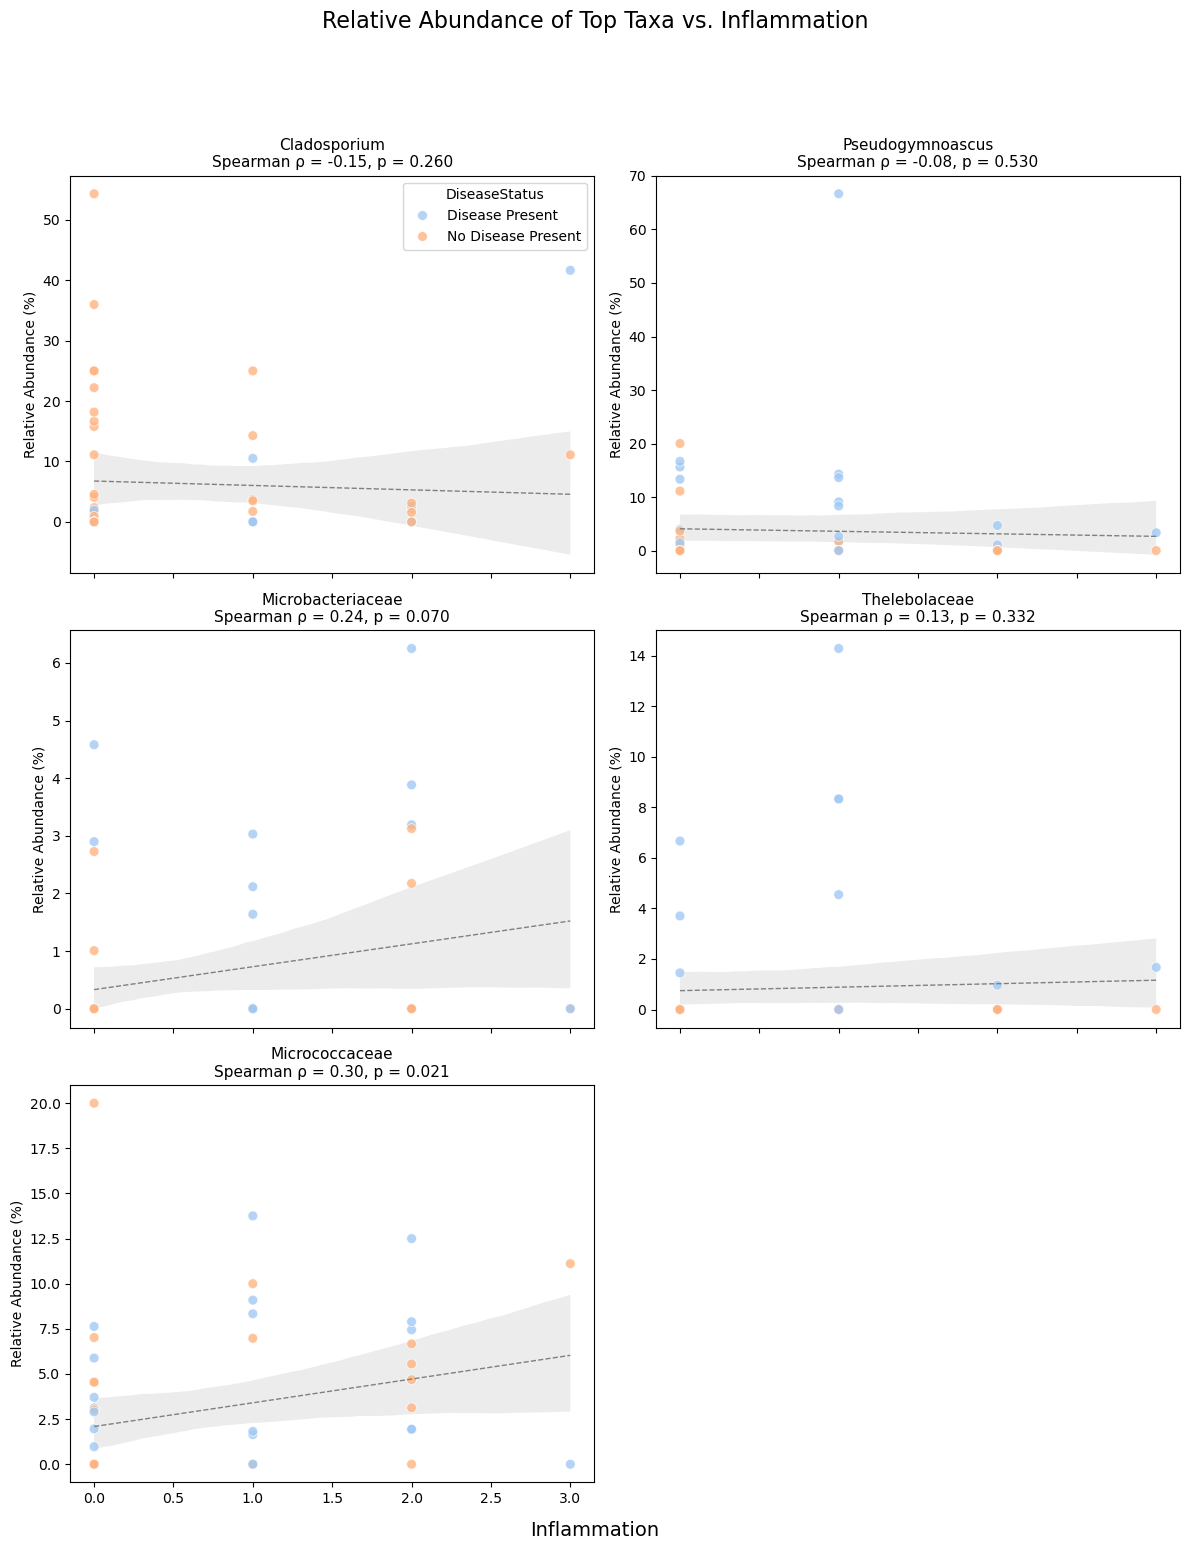


Generating scatter plot grid for 'Necrosis'...
Scatter plot grid saved to 'top_5_taxa_vs_necrosis_scatter_grid.png'


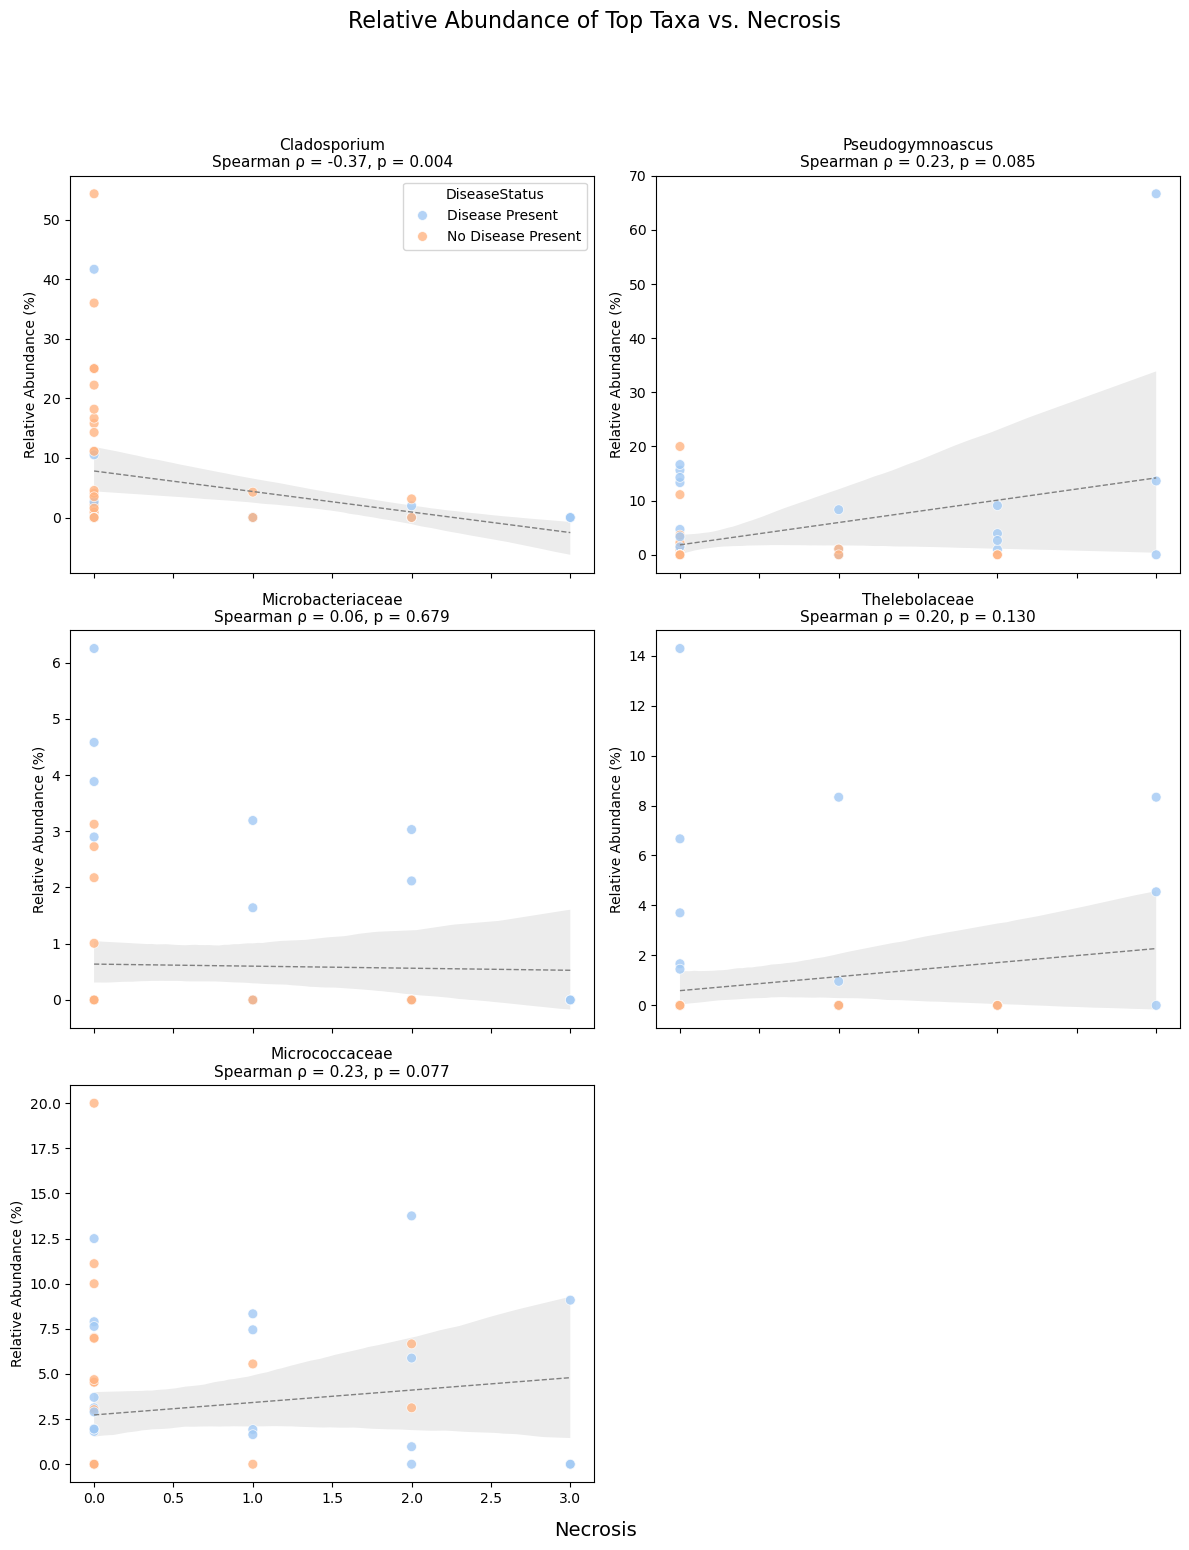

In [20]:
def get_clean_taxon_name_from_display_label(display_label):
    """
    Extracts a cleaner taxon name from the Display_Label for plot labeling.
    Example: "Bacteria: Micrococcus lylae (Species)" -> "Micrococcus lylae"
    """
    if pd.isna(display_label):
        return "Unknown"
    
    parts = str(display_label).split(':', 1)
    name_and_level = parts[-1].strip() # Take the last part after a potential colon
    
    # Remove the level in parentheses at the end
    clean_name = re.sub(r'\s*\(\w+\)$', '', name_and_level).strip()
    
    return clean_name if clean_name else "Unknown"

def prepare_data_for_scatter_plots(
    feature_importance_csv_path,
    otu_table_csv_path,
    metadata_csv_path,
    metadata_sample_id_col="#SampleID",
    metadata_vars_to_include=None,
    hue_col="DiseaseStatus",
    otu_id_col_in_otu_table=None,
    num_taxonomy_cols_in_otu_table=9,
    top_n_taxa=5
):
    """
    Prepares a merged DataFrame for plotting top taxa against metadata variables.
    """
    if metadata_vars_to_include is None:
        metadata_vars_to_include = ["Inflammation", "Necrosis"]

    # 1. Load Data
    try:
        df_importance = pd.read_csv(feature_importance_csv_path)
    except FileNotFoundError: return None
    df_otu_full = pd.read_csv(otu_table_csv_path)
    df_metadata = pd.read_csv(metadata_csv_path)
    print("Successfully loaded all data files.")

    # 2. Identify Top N Taxa
    df_top_taxa = df_importance.nlargest(top_n_taxa, 'Importance').copy()
    if df_top_taxa.empty: return None
    print(f"Identified top {len(df_top_taxa)} important taxa.")
    
    df_top_taxa['Clean_Taxon_Name'] = df_top_taxa['Display_Label'].apply(get_clean_taxon_name_from_display_label)
    top_taxon_id_to_clean_name_map = df_top_taxa.set_index('Taxon_ID')['Clean_Taxon_Name'].to_dict()
    top_taxon_ids = df_top_taxa['Taxon_ID'].tolist()

    # 3. Prepare Abundance Data
    if otu_id_col_in_otu_table is None: otu_id_col_in_otu_table = df_otu_full.columns[0]
    
    df_otu_filtered_for_top_taxa = df_otu_full[df_otu_full[otu_id_col_in_otu_table].isin(top_taxon_ids)].copy()
    if df_otu_filtered_for_top_taxa.empty: return None
    df_otu_filtered_for_top_taxa.set_index(otu_id_col_in_otu_table, inplace=True)
    
    sample_col_pattern = re.compile(r'^[A-Z]\d{2}$')
    potential_sample_cols_start_index = 1 + num_taxonomy_cols_in_otu_table
    sample_cols_otu = [col for col in df_otu_full.columns[potential_sample_cols_start_index:] if sample_col_pattern.match(col)]
    if not sample_cols_otu: sample_cols_otu = [col for col in df_otu_full.columns if sample_col_pattern.match(col)]
    
    df_abundances_top_taxa = df_otu_filtered_for_top_taxa[sample_cols_otu].apply(pd.to_numeric, errors='coerce').fillna(0)
    
    otu_id_col_for_full_sum = df_otu_full.columns[0]
    df_all_numeric_abundances = df_otu_full.set_index(otu_id_col_for_full_sum)[sample_cols_otu].apply(pd.to_numeric, errors='coerce').fillna(0)
    total_sum_per_sample_all_taxa = df_all_numeric_abundances.sum(axis=0)
    total_sum_per_sample_all_taxa[total_sum_per_sample_all_taxa == 0] = 1
    df_relative_abundances = df_abundances_top_taxa.div(total_sum_per_sample_all_taxa, axis='columns') * 100
    
    df_rel_abund_transposed = df_relative_abundances.T
    df_rel_abund_transposed.rename(columns=top_taxon_id_to_clean_name_map, inplace=True)

    # 4. Prepare and Merge Metadata
    cols_to_get_from_metadata = list(set([metadata_sample_id_col] + metadata_vars_to_include + ([hue_col] if hue_col else [])))
    
    missing_meta_cols = [col for col in cols_to_get_from_metadata if col not in df_metadata.columns]
    if missing_meta_cols: return None
        
    df_metadata[metadata_sample_id_col] = df_metadata[metadata_sample_id_col].astype(str)
    for var in metadata_vars_to_include:
        df_metadata[var] = pd.to_numeric(df_metadata[var], errors='coerce')

    df_for_plot = pd.merge(df_rel_abund_transposed, df_metadata[cols_to_get_from_metadata], 
                           left_index=True, right_on=metadata_sample_id_col)
    
    if hue_col:
        classes_to_keep = ['Disease Present', 'No Disease Present']
        df_for_plot = df_for_plot[df_for_plot[hue_col].isin(classes_to_keep)]
    
    if df_for_plot.empty: return None

    return df_for_plot


def create_scatter_grid(data_df, x_var, y_vars, hue_var, output_path):
    """
    Creates and saves a grid of scatter plots for a metadata variable against multiple taxa.
    """
    print(f"\nGenerating scatter plot grid for '{x_var}'...")
    num_plots = len(y_vars)
    # Arrange plots in a grid (e.g., 3x2 for 5 plots)
    ncols = 2
    nrows = (num_plots + ncols - 1) // ncols
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 5 * nrows), sharex=True)
    axes_flat = axes.flatten() # Flatten for easy iteration
    
    for i, y_var in enumerate(y_vars):
        ax = axes_flat[i]
        
        # Create scatterplot with regression line
        sns.regplot(x=x_var, y=y_var, data=data_df, ax=ax, scatter=False,
                    line_kws={'color': 'grey', 'linestyle': '--', 'linewidth': 1})
        sns.scatterplot(x=x_var, y=y_var, hue=hue_var, data=data_df, ax=ax, 
                        palette='pastel', alpha=0.8, s=50) # s is marker size

        # Calculate and annotate Spearman correlation
        corr, p_val = spearmanr(data_df[x_var].dropna(), data_df[y_var].dropna())
        ax.set_title(f"{y_var}\nSpearman ρ = {corr:.2f}, p = {p_val:.3f}", fontsize=11)
        
        ax.set_xlabel('') # Remove individual x-labels
        ax.set_ylabel('Relative Abundance (%)', fontsize=10)
        
        # Handle legend - only show it on the first plot
        if i > 0:
            if ax.get_legend() is not None:
                ax.get_legend().remove()
    
    # Hide any unused subplots
    for j in range(num_plots, len(axes_flat)):
        axes_flat[j].set_visible(False)
        
    # Set a common x-label for the whole figure
    fig.supxlabel(x_var, fontsize=14)
    fig.suptitle(f"Relative Abundance of Top Taxa vs. {x_var}", fontsize=16, y=1.03)
    
    plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust for suptitle
    
    try:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"Scatter plot grid saved to '{output_path}'")
        plt.show()
    except Exception as e:
        print(f"Error saving plot: {e}")
    plt.close()


if __name__ == "__main__":
    feature_importance_file = "random_forest_binary_disease_vs_no_disease_diagnostics/all_taxa_importances_annotated_binary_tuned.csv" 
    otu_table_file = "otu_table_uclust_with_updated_taxonomy_05172025_78bats_singletsRemoved_78bats_filtered_domains_combined_by_genus_keep_blanks_species_column_removed.csv"
    meta_file = "otu_metadata_uclust_updated_taxonomy_05162025.csv" 
    
    metadata_sample_id_col_main = "SampleID" 
    metadata_variables_to_plot_main = ["Inflammation", "Necrosis"]
    hue_column_main = "DiseaseStatus"
    
    otu_id_col_name_in_otu_table = None
    num_tax_cols = 9 
    top_n_for_plot = 5 
    
    # Check that all files exist before proceeding
    if not all(os.path.exists(f) for f in [feature_importance_file, otu_table_file, meta_file]):
        print("CRITICAL ERROR: One or more required input files were not found. Please check file paths.")
    else:
        # Prepare the single data frame needed for all plots
        df_to_plot = prepare_data_for_scatter_plots(
            feature_importance_csv_path=feature_importance_file,
            otu_table_csv_path=otu_table_file,
            metadata_csv_path=meta_file,
            metadata_sample_id_col=metadata_sample_id_col_main,
            metadata_vars_to_include=metadata_variables_to_plot_main,
            hue_col=hue_column_main,
            otu_id_col_in_otu_table=otu_id_col_name_in_otu_table,
            num_taxonomy_cols_in_otu_table=num_tax_cols,
            top_n_taxa=top_n_for_plot
        )

        if df_to_plot is not None and not df_to_plot.empty:
            top_taxa_clean_names = [col for col in df_to_plot.columns if col not in [metadata_sample_id_col_main, "Inflammation", "Necrosis", "DiseaseStatus"]]
            
            # Create a separate plot for each metadata variable
            for meta_var in metadata_variables_to_plot_main:
                output_filename = f"top_{top_n_for_plot}_taxa_vs_{meta_var.lower()}_scatter_grid.png"
                create_scatter_grid(
                    data_df=df_to_plot,
                    x_var=meta_var,
                    y_vars=top_taxa_clean_names,
                    hue_var=hue_column_main,
                    output_path=output_filename
                )
        else:
            print("Could not generate data for plotting. Exiting.")
